In this step, we import the required libraries and load our dataset directly from Google Drive. Storing the dataset in the same directory as the notebook helps ensure smooth access and avoids file-path issues.

This dataset contains historical retail transactions including inventory levels, sales, promotions, pricing, and weather information.

In [39]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Inventory stock risk/retail_store_inventory.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


Before building any machine learning model, it is essential to understand the structure of the dataset. Here, we begin by reviewing the column names and data types to evaluate what each feature represents and how it may contribute to predicting stockout risk. This step helps us identify which features need cleaning, encoding, transformation, or engineering later in the workflow.

In [8]:
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')



*   Identify NULL values



In [9]:
df.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


*   Identify duplicate values


In [10]:
df.duplicated().sum()


np.int64(0)



*   Identify Value Type




In [11]:
df.dtypes


,0
Date,object
Store ID,object
Product ID,object
Category,object
Region,object
Inventory Level,int64
Units Sold,int64
Units Ordered,int64
Demand Forecast,float64
Price,float64


The Date column is initially stored as an object (string), which limits our ability to extract useful time-based information. In this step, we convert it into a datetime data type so we can perform operations such as sorting by date and engineering additional features like day of the week, month, and seasonal patterns that may influence stockout risk.

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.dtypes

,0
Date,datetime64[ns]
Store ID,object
Product ID,object
Category,object
Region,object
Inventory Level,int64
Units Sold,int64
Units Ordered,int64
Demand Forecast,float64
Price,float64


In [14]:
df.describe()


,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,2022-12-31 23:59:59.999999744,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
min,2022-01-01 00:00:00,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,2022-07-02 00:00:00,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,2023-01-01 00:00:00,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,2023-07-03 00:00:00,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,2024-01-01 00:00:00,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000
std,NaN,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408


In [15]:
import numpy as np

To build a predictive model, we first need to define what “at risk of stockout” means. We experimented with two approaches:

First Attempt — Fixed Inventory Threshold

In [16]:
"""threshold = 10
df['stockout_risk'] = np.where(df['Inventory Level'] < threshold, 1, 0)"""

This simple rule assumes that any product with low remaining units (e.g., < 10) is at risk.
However, this does not consider how fast each product sells.
A product may have only 5 units left but sells only 1 unit per week → not at risk.

So we improved it.

In [18]:
df['stockout_risk'].value_counts()

,count
stockout_risk,
0,73100


Final Approach — Compare Inventory to Demand Forecast

This method is more realistic, because:

* Includes expected demand instead of guessing.
* Adjusts to each product’s sales behavior.
* Detects risk even with high inventory if demand is much higher.
* Represents actual business decision-making

In [19]:
df['stockout_risk'] = np.where(df['Inventory Level'] < df['Demand Forecast'], 1, 0)

We now have a meaningful target label that matches the real world:
A product is at stockout risk when expected demand exceeds what is available.

In [21]:
df['stockout_risk'].value_counts()

,count
stockout_risk,
0,70515
1,2585


Our next cell includes the most important part (***Feauture Engineering***)

To help our model understand the real-world patterns behind stockouts, we create additional features that capture time behavior, pricing dynamics, and promotion effects. These engineered features often provide stronger predictive power than raw data.

Time Features: These features capture how demand changes throughout the week and across seasons.

Examples:

* Certain products sell more on weekends: higher stockout risk
* Holiday months (e.g., December) often spike demand
* Weekly cycles help the model learn recurring demand patterns

Price competition: This feature helps identify if a product is priced higher or lower than competitors.

Why it matters:

* If your price is much lower, sales may spike :higher stockout risk
* If your price is higher, demand may drop

Discount flag features : Discounts and promotions significantly boost demand.

A simple 0–1 flag helps the model capture the effect of temporary promotions without overfitting to raw discount values.

In [22]:
# Time features
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Price competitiveness
df['price_competition_diff'] = df['Price'] - df['Competitor Pricing']

# Discount flag
df['discount_flag'] = (df['Discount'] > 0).astype(int)


In [23]:
df.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Holiday/Promotion,Competitor Pricing,Seasonality,stockout_risk,day_of_week,month,week,is_weekend,price_competition_diff,discount_flag
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,0,29.69,Autumn,0,5,1,52,1,3.81,1
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,...,0,66.16,Autumn,0,5,1,52,1,-3.15,1
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,...,1,31.32,Summer,0,5,1,52,1,-3.33,1
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,...,1,34.74,Autumn,0,5,1,52,1,-2.02,1
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,...,0,68.95,Summer,0,5,1,52,1,4.69,0


Before calculating rolling averages and demand trends, we must ensure that the data for each Store + Product is arranged in the correct chronological order. Sorting the dataset by Store ID, Product ID, and Date guarantees that the time-based features we compute reflect the true order of sales and inventory events.

Without sorting, rolling windows would mix up dates, leading to inaccurate or misleading trends.


In [24]:
df = df.sort_values(['Store ID', 'Product ID', 'Date'])

Before training any machine learning model, it’s important to understand how balanced or imbalanced the target classes are. Here, we count how many rows fall into each category of stockout_risk (0 = not at risk, 1 = at risk):

In [35]:
df['stockout_risk'].value_counts()


,count
stockout_risk,
0,70515
1,2585


Different products have different sales patterns over time. To help the model understand whether demand is rising or falling, we compute rolling averages of units sold for each Store + Product combination:


* 7-day average : captures recent spikes (e.g., weekend rush : stockout risk increases)

* 30-day average : captures overall long-term product demand

Helps detect trends, seasonality, and sudden changes in buying behavior

These features give the model a better view of how fast inventory is being consumed , one of the most important drivers of stockouts.

In [25]:
# Rolling averages of Units Sold per Store–Product over time
df['units_sold_7d_avg'] = (
    df.groupby(['Store ID', 'Product ID'])['Units Sold']
      .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

df['units_sold_30d_avg'] = (
    df.groupby(['Store ID', 'Product ID'])['Units Sold']
      .transform(lambda x: x.rolling(window=30, min_periods=1).mean())
)


To understand whether a product’s demand is increasing or decreasing, we create a feature that compares short-term demand to long-term demand:

How to interpret it:

* Positive value: recent demand is higher than usual → risk of stockout increases

* Negative value: demand is slowing down → stockout risk decreases

* Around zero: stable demand

In [26]:
df['demand_trend'] = df['units_sold_7d_avg'] - df['units_sold_30d_avg']


In [27]:
df[['Date', 'Store ID', 'Product ID', 'Units Sold',
    'units_sold_7d_avg', 'units_sold_30d_avg', 'demand_trend']].head(15)


,Date,Store ID,Product ID,Units Sold,units_sold_7d_avg,units_sold_30d_avg,demand_trend
0,2022-01-01,S001,P0001,127,127.000000,127.000000,0.000000
100,2022-01-02,S001,P0001,81,104.000000,104.000000,0.000000
200,2022-01-03,S001,P0001,5,71.000000,71.000000,0.000000
300,2022-01-04,S001,P0001,58,67.750000,67.750000,0.000000
400,2022-01-05,S001,P0001,147,83.600000,83.600000,0.000000
500,2022-01-06,S001,P0001,37,75.833333,75.833333,0.000000
600,2022-01-07,S001,P0001,107,80.285714,80.285714,0.000000
700,2022-01-08,S001,P0001,2,62.428571,70.500000,-8.071429
800,2022-01-09,S001,P0001,350,100.857143,101.555556,-0.698413
900,2022-01-10,S001,P0001,36,105.285714,95.000000,10.285714


From here we are starting our final step , where we are getting ready to build our prediction model

Before building the machine learning model, we define which features (inputs) will be used to predict stockout risk. We separate the dataset into:

* Numeric Features: Includes original values (like inventory levels and price), time-based features, and engineered demand trends.
These help the model understand how inventory changes over time, pricing influence, and demand patterns.

* Categorical Features: Store identity, product category, region, and seasonality topics that impact demand differently:

In [28]:
feature_cols = [
    # Numeric originals
    'Inventory Level', 'Units Sold', 'Units Ordered',
    'Demand Forecast', 'Price', 'Discount',
    'Holiday/Promotion', 'Competitor Pricing',

    # Time features
    'day_of_week', 'month', 'week', 'is_weekend',

    # Engineered numeric features
    'price_competition_diff', 'discount_flag',
    'units_sold_7d_avg', 'units_sold_30d_avg', 'demand_trend']

categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region','Weather Condition', 'Seasonality']

Now that we have selected the relevant features for our model, we separate the dataset into:

X: The input features that will help the model learn patterns

y: The target label we want to predict (whether an item is at stockout risk

In [29]:
X = df[feature_cols + categorical_cols]
y = df['stockout_risk']

In this section, we import the core tools needed to build, preprocess, and evaluate our machine learning model

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

To properly evaluate the model’s performance, we split the dataset into:

Training set (80%) : used to train the model

Test set (20%) : used only for final evaluation on unseen data

We also use stratified sampling to maintain the same percentage of stockout vs. non-stockout cases in both sets (important because our data is imbalanced).

In [30]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

Since our dataset contains both numeric and categorical features, we need to preprocess each type correctly before feeding them into the model. In this step, we define a transformation pipeline that handles everything automatically:

For all numeric features, we apply StandardScaler, which normalizes values to a similar range. This prevents any single feature (like price or inventory level) from dominating the model simply because of its scale.

For categorical features, we use OneHotEncoder, converting each category (such as store, product, region, or weather condition) into numerical format so the model can understand it. We also set handle_unknown='ignore' to ensure the model can still process new or unseen category values in real future scenarios — such as adding a new product line or opening a new store.

Bringing these steps together into a ColumnTransformer helps us build a fully automated and repeatable pipeline. This ensures that every time data flows into the model — during training or prediction — it goes through the exact same preprocessing steps, reducing errors and improving reliability when deployed.

In [32]:
numeric_features = feature_cols  # all numeric ones we listed above

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

We begin with a Random Forest Classifier as our baseline model to predict stockout risk. Random Forest is a strong first choice because it handles mixed feature types well and identifies non-linear patterns in the data.

What’s happening here:

* n_estimators=200
  
  Trains 200 decision trees and combines their predictions for better accuracy and stability.

* class_weight='balanced'

  Because stockout cases (class 1) are rare, this helps the model pay more attention to the minority class so it doesn’t ignore important risk cases.

The model is wrapped inside a Pipeline, which means:
* Preprocessing (scaling + encoding)
* and Model training happen together in one smooth operation , preventing data leakage and making deployment easier.

This step trains the first version of our predictive system, giving us a baseline to measure against as we improve model performance later.

In [33]:
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'  # because class 1 is much rarer
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', clf)
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Inventory Level',
                                                   'Units Sold',
                                                   'Units Ordered',
                                                   'Demand Forecast', 'Price',
                                                   'Discount',
                                                   'Holiday/Promotion',
                                                   'Competitor Pricing',
                                                   'day_of_week', 'month',
                                                   'week', 'is_weekend',
                                                   'price_competition_diff',
                                                   'discount_flag',
                                                   'units_sold_7d_avg',
                                                   'units_sold_30d_avg',
                                                   'demand_trend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store ID', 'Product ID',
                                                   'Category', 'Region',
                                                   'Weather Condition',
                                                   'Seasonality'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

These evaluation metrics help us understand:

* How many stockout cases did the model correctly detect?

* How many did it miss?

* Is it biased toward predicting only the majority class (no stockout)?

In [34]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[14103     0]
 [  516     1]]
              precision    recall  f1-score   support

           0      0.965     1.000     0.982     14103
           1      1.000     0.002     0.004       517

    accuracy                          0.965     14620
   macro avg      0.982     0.501     0.493     14620
weighted avg      0.966     0.965     0.947     14620



🔍 What We Observed

Although the model achieved a high overall accuracy, it performed very poorly on the minority class , products at risk of stockout.

Why did this happen?

* The dataset is highly imbalanced
(Only ~3.5% of records represent a stockout risk)

* Random Forest tended to predict mostly class 0 (no stockout)
…because it sees much more of that during training

As a result:

* Recall for stockout cases was extremely low

* Many at-risk products were not detected

* This is unacceptable for real retail operations

**Business Implication**

Missing stockout predictions means stores run out of products and lose sales revenue, especially for high-demand items.

So while this baseline model gives us a solid start, we clearly need a strategy that better handles class imbalance — leading us to apply SMOTE + XGBoost in the next step for major improvements.

In [36]:
!pip install imbalanced-learn xgboost

Since Our baseline Random Forest model struggled to detect stockout cases due to severe class imbalance: most records were “no stockout” (class 0), and only a small fraction represented “stockout risk” (class 1). To address this, we combine two powerful techniques:

1. SMOTE (Synthetic Minority Oversampling Technique) to balance the training data

2. XGBoost, a gradient boosting model well-suited for imbalanced classification problems

Together, these help the model focus on correctly identifying stockout risk instead of always favoring the majority class.

Here:

* We first preprocess the training and test data using the same transformations as before (scaling + encoding).

* We then apply SMOTE only to the training set, creating synthetic examples of the minority class (stockout risk) so the model can learn from more positive cases.

* We calculate scale_pos_weight to further tell XGBoost that misclassifying stockout cases should be penalized more than misclassifying non-stockout cases.

* We train an XGBoost classifier on the resampled (balanced) training data.

* Finally, we evaluate on the original, untouched test set so that our metrics reflect real-world performance.

In [40]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

#preprocess X_train and X_test using the same preprocessor as before
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

#apply SMOTE on the TRAINING data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_res.value_counts())

#compute class weight for XGBoost (still helpful even after SMOTE)
neg = (y_train_res == 0).sum()
pos = (y_train_res == 1).sum()
scale_pos_weight = neg / pos

#XGBoost model
xgb_clf = XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=6,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',eval_metric='logloss',
                        scale_pos_weight=scale_pos_weight,random_state=42,n_jobs=-1)

#train on the resampled data
xgb_clf.fit(X_train_res, y_train_res)

#evaluate on ORIGINAL test set (no SMOTE here!)
y_pred_xgb = xgb_clf.predict(X_test_proc)

print("Confusion matrix (XGBoost + SMOTE):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification report (XGBoost + SMOTE):")
print(classification_report(y_test, y_pred_xgb, digits=3))


Before SMOTE:
stockout_risk
0    56412
1     2068
Name: count, dtype: int64

After SMOTE:
stockout_risk
0    56412
1    56412
Name: count, dtype: int64
Confusion matrix (XGBoost + SMOTE):
[[14071    32]
 [   51   466]]

Classification report (XGBoost + SMOTE):
              precision    recall  f1-score   support

           0      0.996     0.998     0.997     14103
           1      0.936     0.901     0.918       517

    accuracy                          0.994     14620
   macro avg      0.966     0.950     0.958     14620
weighted avg      0.994     0.994     0.994     14620



After applying SMOTE + XGBoost, recall for stockout risk improved from 0.2% to ~90%, while overall accuracy increased as well.

To understand what the model has learned, we analyze the feature importance scores from XGBoost. This helps us identify which variables contribute most to predicting stockout risk , a key requirement for real-world retail decision-making.



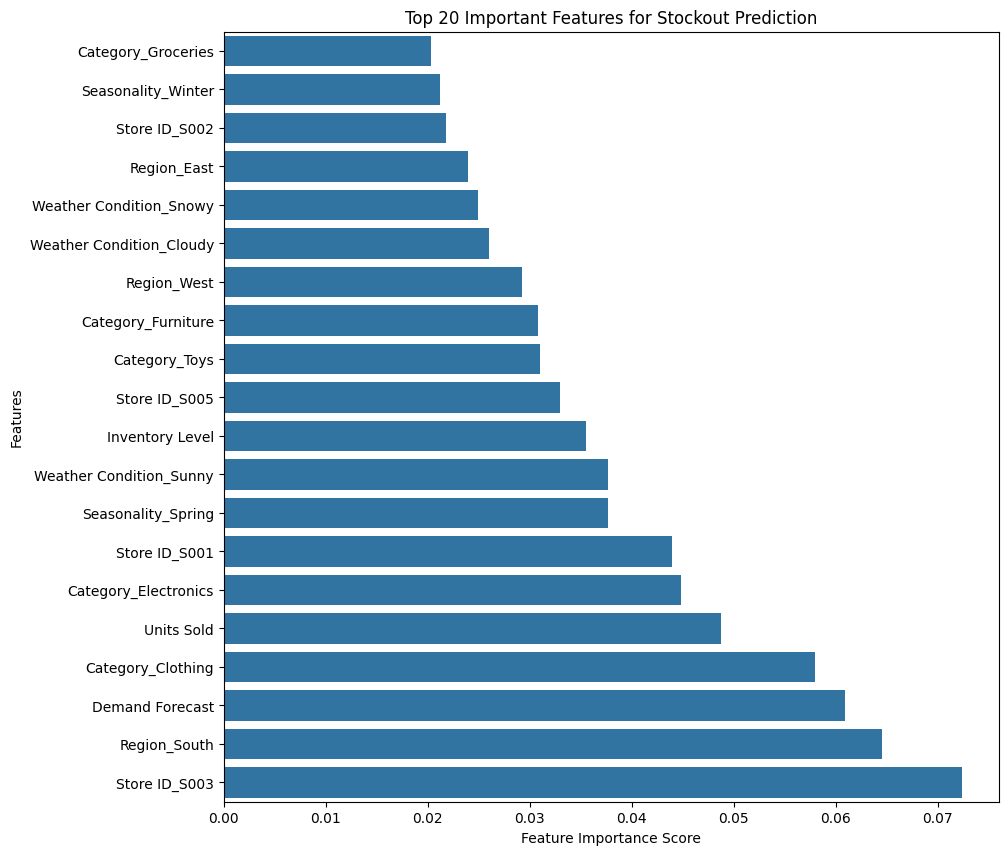

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_features = numeric_features
cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
all_features = num_features + cat_features

importances = xgb_clf.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 10))
sns.barplot(x=importances[indices], y=np.array(all_features)[indices])
plt.title("Top 20 Important Features for Stockout Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()


The feature importance results reveal that Demand Forecast, Units Sold, and Inventory Level are the strongest indicators of stockout risk confirming that stockouts occur when demand rapidly outpaces available stock. Additionally, both Region and Product Category play a significant role, showing that stockout risk varies based on where and what products are sold. For example, locations like Region_South and product types such as Clothing and Electronics show higher sensitivity to demand surges.

Seasonal and weather-related factors also appear in the top contributors, suggesting that environmental and seasonal patterns influence consumer behavior with stockouts more likely during specific seasons like Spring, or under particular weather conditions such as Sunny days that may increase store traffic. Finally, the presence of specific store IDs among the top features indicates that individual stores have unique operational patterns, making predictive modeling crucial for store-level inventory planning.

**Business Takeaway**

Stockout risk is driven by consistently high demand combined with location- and category-specific behaviors, influenced further by seasonal and weather changes.
Retailers can leverage these insights to prioritize inventory allocation to high-risk stores and products, reducing lost sales and improving customer satisfaction.